# Parameter estimation

This notebook contains model inference for the second-round of intein-based logic AND gate.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from scipy.optimize import curve_fit
from scipy.integrate import odeint

import tqdm

import warnings
warnings.filterwarnings('ignore')

## Import datasets

In [2]:
#bulk fluorescence data
fluo_raw_1 = pd.read_csv('datasets/bulk_fluo_plate_1.csv', index_col=0)
fluo_raw_2 = pd.read_csv('datasets/bulk_fluo_plate_2.csv', index_col=0)
#od only data
od_raw_1 = pd.read_csv('datasets/od_plate_1.csv', index_col=0)
od_raw_2 = pd.read_csv('datasets/od_plate_2.csv', index_col=0)

In [3]:
incorrect = ['e16x30MjaKlbA', 'e26x30TerThyXS1', 'e34x30TvoVMA', 'e38x32NrdA2', 'e42x30MjaKlbA', 'e33',
            'e34x30SspGyrB.1', 'e38x30SspGyrB.1', 'e16x32gp418.1', 'e22x30gp418', 'e20x30MjaKlbA',
            'e17x32NrdA2.1', 'e34x33NrdA2.1', 'gfp_med_1', 'gfp_med_2', 'gfp_low', 'gfp_low_1', 'gfp_low_2',
            'e15', 'e17', 'e20', 'e26']
fluo = pd.concat([fluo_raw_1, fluo_raw_2], axis=1)
fluo = fluo.drop(incorrect, axis=1)
fluo = fluo.rename(columns={'e22x30gp418.1': 'e22x30gp418', 'e20x30MjaKlbA.1': 'e20x30MjaKlbA'})
od = pd.concat([od_raw_1, od_raw_2], axis=1)
od = od.drop(incorrect, axis=1)

In [4]:
gfp_fluo_1 = fluo_raw_1['gfp_med_1']
gfp_fluo_2 = fluo_raw_2['gfp_med_1']
gfp_od_1 = od_raw_1['gfp_med_1']
gfp_od_2 = od_raw_2['gfp_med_1']

In [5]:
ecfs = list(set([i[:3] for i in fluo.columns.tolist()]))
ints = list(set([i[6:] for i in fluo.columns.tolist()]))
#ints.remove('')
#ints.remove('d_1')
#ints.remove('d_2')
#ints.remove('w_1')
#ints.remove('w_2')
#ints.remove('w')
len(ecfs), len(ints)

(13, 23)

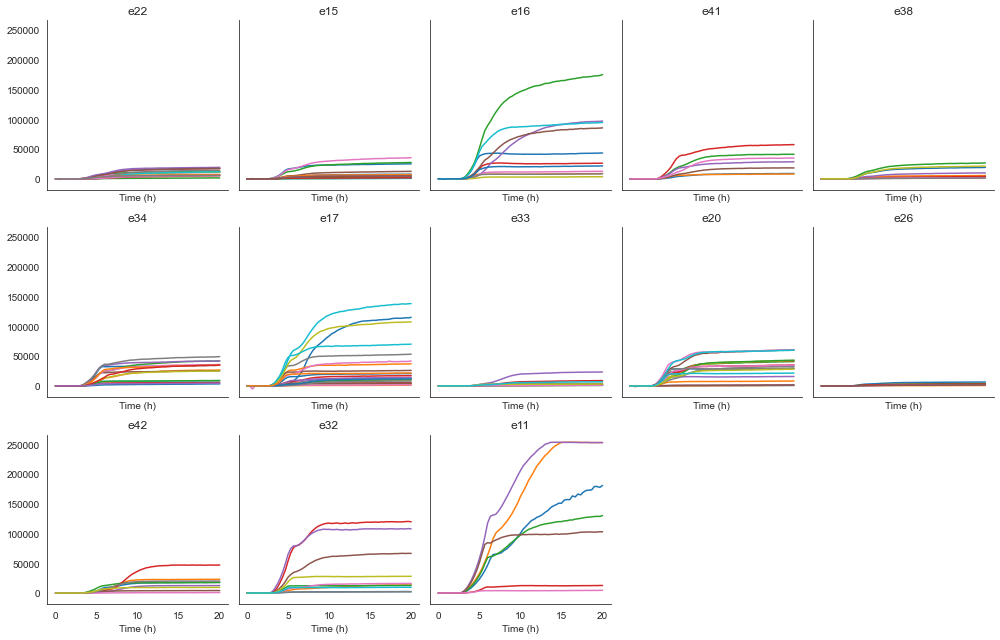

In [6]:
def plot_ecfs_ints(by_what, num_row, num_col, flag=True):
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(by_what):
            if flag:
                data = fluo[[j for j in fluo.columns.tolist() if j.startswith(by_what[i])]]
            else:
                data = fluo[[j for j in fluo.columns.tolist() if j[6:]==by_what[i]]]
            ax.plot(data.index/60, data)
            ax.set_title(by_what[i])
            #plt.xticks(rotation=90)
            ax.set_xlabel('Time (h)')
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
#plot bulk fluorescence data
plot_ecfs_ints(ecfs, 3, 5)

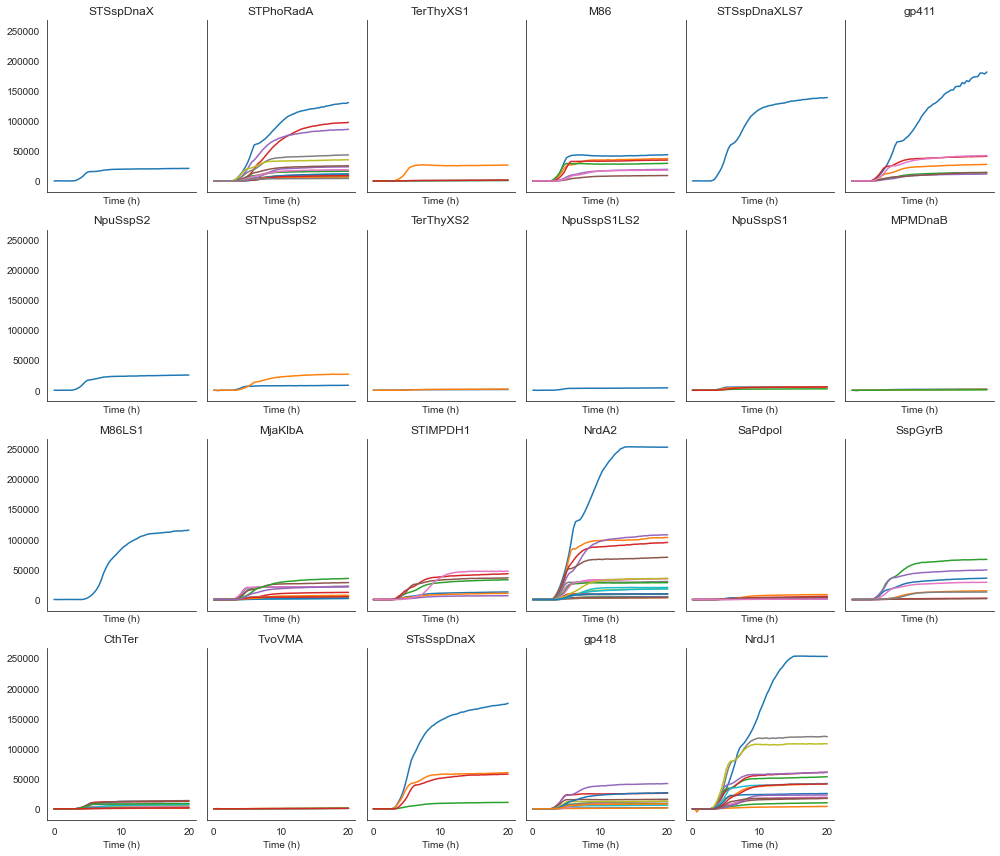

In [7]:
plot_ecfs_ints(ints, 4, 6, False)

### Selected by manual inspection

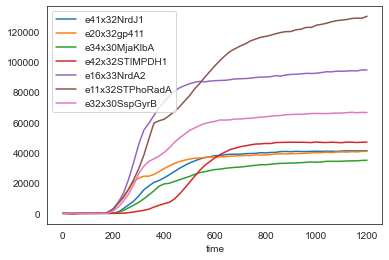

In [8]:
selected = ['e41x32NrdJ1', 'e20x32gp411', 'e34x30MjaKlbA', 'e42x32STIMPDH1',
           'e16x33NrdA2', 'e11x32STPhoRadA', 'e32x30SspGyrB']
fluo_selected = fluo[selected]
od_selected = od[selected]
fluo_selected.plot()
plt.show()

In [9]:
num_traces = fluo_selected.shape[1]
num_traces

7

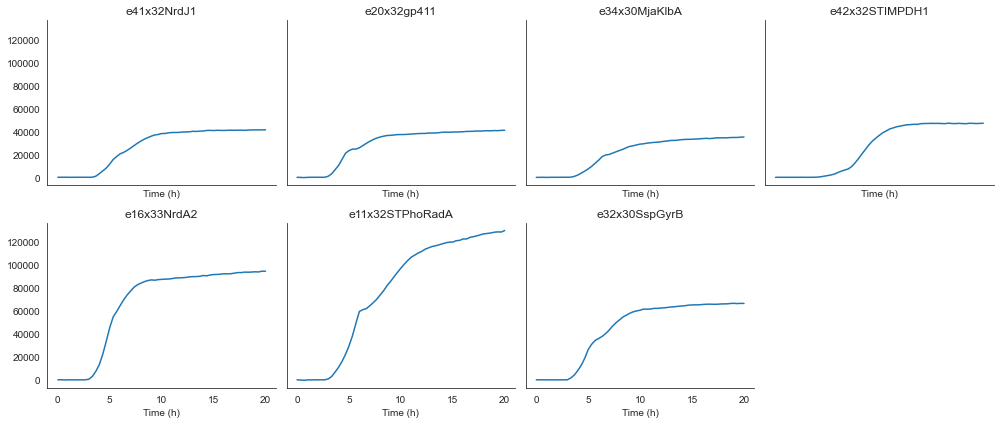

In [10]:
def plot_all(data, num_row, num_col):
    f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < num_traces:
            ax.plot(data.index/60, data.iloc[:, i])
            ax.set_title(data.columns[i])
            #plt.xticks(rotation=90)
            ax.set_xlabel('Time (h)')
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()
    
#plot bulk fluorescence data
plot_all(fluo_selected, 2, 4)

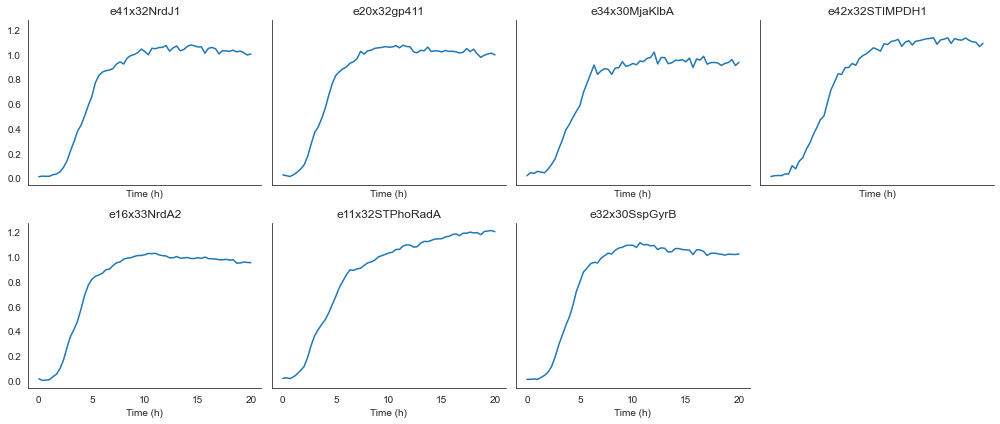

In [11]:
plot_all(od_selected, 2, 4)

## Modeling OD

Changes:
- Also fitting the initial density $c_0$. Without this, the shape isn't quite right.
- Using the real time values, instead of np.arange

In [12]:
def growth_rate(t, OD, alpha, beta):
    return (alpha * (1 - (OD/beta)))

### Functions for 1st level inference (fitting growth data) ###
def od_wrapper(t, k1, k2, c0):
    
    def od_model(OD, t, mgr, mcc):
        dOD = growth_rate(t, OD[0], mgr, mcc) * OD[0]
        return dOD
    
    od_rates = (k1, k2)
    od_sol = odeint(od_model, c0, t, od_rates)
    return od_sol[:,0]

In [13]:
od_bounds = [(0, 0, 0), (1, 2, 0.1)]
od_params = []
od_t = od_selected.index
for idx in range(num_traces):
    od_data = od_selected[od_selected.columns[idx]]
    opt, _ = curve_fit(od_wrapper, od_t, od_data, bounds=od_bounds)
    od_params.append(opt)

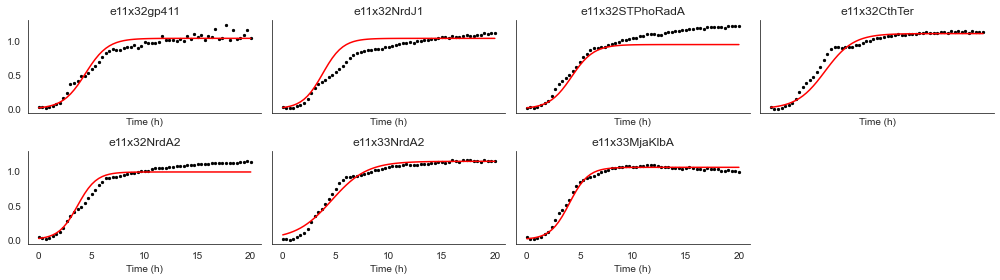

In [14]:
num_col = 4
num_row = 2
f, axs = plt.subplots(num_row, num_col, sharex=True, sharey=True, figsize=(14, num_row*2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < num_traces:
        r, K, c0 = od_params[i]
        ax.scatter(od_t / 60, od.iloc[:, i], c='k', s=5)
        ax.plot(od_t / 60, od_wrapper(od_t, r, K, c0), c='r')
        ax.set_title(od.columns[i])
        ax.set_xlabel('Time (h)')
    else:
        ax.set_visible(False)
plt.tight_layout()
sns.despine()

### Define inference helper and fixed functions

In [20]:
def compare_model_data(f_t, f_data, f_sim, ax):
    ax.scatter(f_t / 60, f_data, c='r', s=10)
    ax.plot(f_t / 60, f_sim, c='k')
    ax.set_xlabel('Time (h)')
    
def plot_parameters(f_df, bounds):
    parameters = f_df[0]['Parameters'].values
    n_paras = len(parameters)
    values = np.stack([df['Value'].values for df in f_df])
    errors = np.stack([df['Err'].values for df in f_df])

    f, axs = plt.subplots(n_paras, 1, sharex=True, figsize=(12, 1.5*(n_paras+1)))
    for i, ax in enumerate(axs):
        ax.errorbar(fluo_selected.columns, values[:,i], errors[:,i], fmt='.')
        #ax.set_ylim(bounds[0][i], bounds[1][i])
        ax.set_ylabel(parameters[i])
    plt.xticks(rotation=90)
    sns.despine()
    
def plot_comparisons(f_sim, f_data):
    fig, axs = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(14, 4))
    axr = axs.ravel()

    for i, ax in enumerate(axr):
        if i < num_traces:
            ax = axr[i]
            compare_model_data(f_t, f_data[i], f_sim[i], ax)
            ax.set_title(fluo_selected.columns[i])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()

## Modelling fluorescence

The limitation of this model is that it assumes the GFP degrades, but it is supposed to be negligble. Can we assume that the degradation rate here is the resource limitation?

In [119]:
#model
def hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper(t, syn_ECFn, syn_ECFc, syn_ECF, deg, syn_GFP, deg_GFP, K, n, extra, y0):
    
    #fixed parameters
    alpha, beta = extra

    def gate_model(y, t):
    
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = syn_ECFn - (deg + gamma) * ECFn
        dECFc = syn_ECFc - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = syn_GFP * hill_equation(ECF, K, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

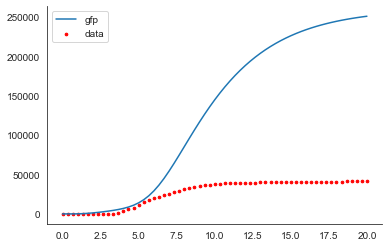

In [120]:
def plot_model(idx, fluo=fluo_selected, od_params=od_params, show_data=True, show_all=False):

    f_data = fluo.iloc[:,idx]
    f_t = fluo.index
    alpha, beta, c0 = od_params[idx]
    y0 = [0, 0, 0, 0, c0]
    extra = (alpha, beta)
    
    def model_fit(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, extra, y0)
        return fit
    
    model = model_fit(f_t, 1, 1, 0.000005, 0.010594, 1187.391794, 0.004312, 1.0, 2.000000)
    ecfn = pd.Series(model[0], index=f_t/60)
    ecfc = pd.Series(model[1], index=f_t/60)
    ecf = pd.Series(model[2], index=f_t/60)
    gfp = pd.Series(model[3], index=f_t/60)
    od = pd.Series(model[4], index=f_t/60)

    if show_data:
        plt.scatter(f_t/60, f_data, s=7, c='r', label='data')
    if show_all:
        sns.lineplot(ecfn, label='ecfn')
        sns.lineplot(ecf, label='ecf')
        sns.lineplot(od, label='od')
    plt.plot(gfp, label='gfp')
    plt.legend()
    sns.despine()
    plt.show()
    
plot_model(0)

[3.49222058e+00 3.71564938e+00 3.23826764e-07 1.02465159e-05
 3.65145688e+02 8.88510834e-03 1.62878098e+00 2.00000000e+00]


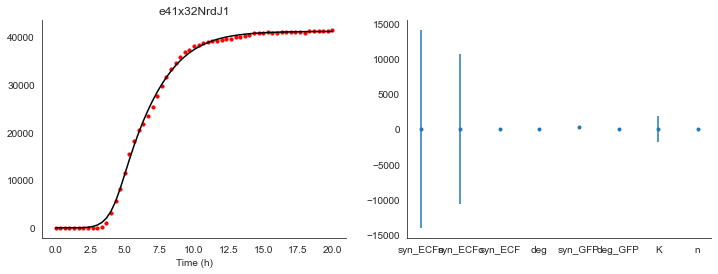

In [121]:
def fit_deg_stable_gfp(idx):
    
    f_data = fluo_selected.iloc[:,idx]
    f_t = fluo_selected.index
    title = fluo_selected.columns[idx]
    alpha, beta, c0 = od_params[idx]
    y0 = [0, 0, 0, 0, c0]
    extra = (alpha, beta)
    
    parameters = ['syn_ECFn', 'syn_ECFc', 'syn_ECF', 'deg', 'syn_GFP', 'deg_GFP', 'K', 'n']
    init_guess = [1, 1, 1e-6, 1e-3, 1e2, 1e-2, 1, 2]
    gate_bounds_together = [np.array(init_guess)*0, np.array(init_guess)*100]
    
    def model_fit(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, 4, extra, y0)
        return fit[3]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    print(f_params)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data 

idx = 0
f_df, f_sim, f_data = fit_deg_stable_gfp(idx)
f_t = f_data.index
f, axs = plt.subplots(1, 2, figsize=(12, 4))
compare_model_data(f_t, f_data, f_sim, axs[0])
axs[0].set_title(fluo_selected.columns[idx])
axs[1].errorbar(f_df['Parameters'], f_df['Value'], f_df['Err'], fmt='.')

sns.despine()

In [122]:
f_df_deg, f_sim_deg, f_data_deg = zip(*[fit_deg_stable_gfp(idx) for idx in tqdm.trange(len(od_params))])


 14%|█▍        | 1/7 [00:01<00:08,  1.36s/it]

[3.49222058e+00 3.71564938e+00 3.23826764e-07 1.02465159e-05
 3.65145688e+02 8.88510834e-03 1.62878098e+00 2.00000000e+00]



 29%|██▊       | 2/7 [00:07<00:21,  4.20s/it]

[3.57877405e+00 2.82144681e+00 7.28180433e-07 6.53119119e-06
 4.74199113e+02 1.20901634e-02 1.77252299e+00 2.00000000e+00]



 43%|████▎     | 3/7 [00:09<00:11,  2.99s/it]

[2.96829320e+00 3.07155491e+00 3.05572496e-07 7.31578646e-05
 2.25878331e+02 6.61782999e-03 1.06550474e+00 2.00000000e+00]



 57%|█████▋    | 4/7 [00:11<00:08,  2.80s/it]

[5.17356718e-01 4.68566742e-01 7.62650090e-06 6.25644391e-03
 5.00905816e+02 1.05357957e-02 1.01572095e+00 2.00000000e+00]



 71%|███████▏  | 5/7 [00:13<00:04,  2.40s/it]

[7.19163172e+00 2.84736932e+00 1.98861617e-06 8.11097875e-07
 1.19526934e+03 1.30622425e-02 1.19034724e+01 2.00000000e+00]



 86%|████████▌ | 6/7 [00:14<00:01,  1.92s/it]

[5.51478734e+00 6.83660917e+00 4.77179925e-08 3.47682293e-04
 6.66041048e+02 5.08540309e-03 1.26804218e+00 2.00000000e+00]



100%|██████████| 7/7 [00:16<00:00,  2.30s/it]

[5.23794287e+00 6.11176342e+00 1.27637180e-07 2.79862903e-07
 5.19979126e+02 7.88895029e-03 8.83880921e-01 2.00000000e+00]


  0%|          | 0/7 [19:32<?, ?it/s]


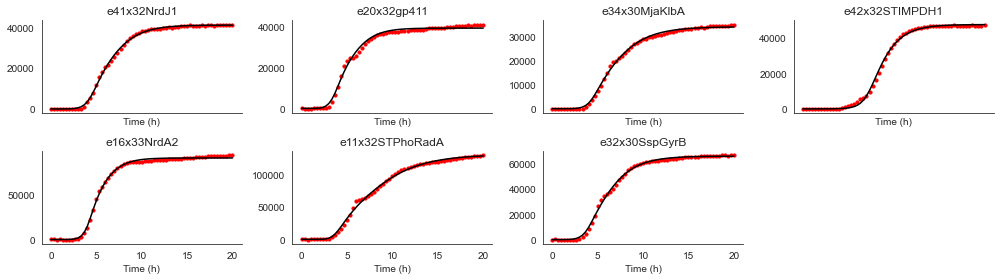

In [123]:
plot_comparisons(f_sim_deg, f_data_deg)

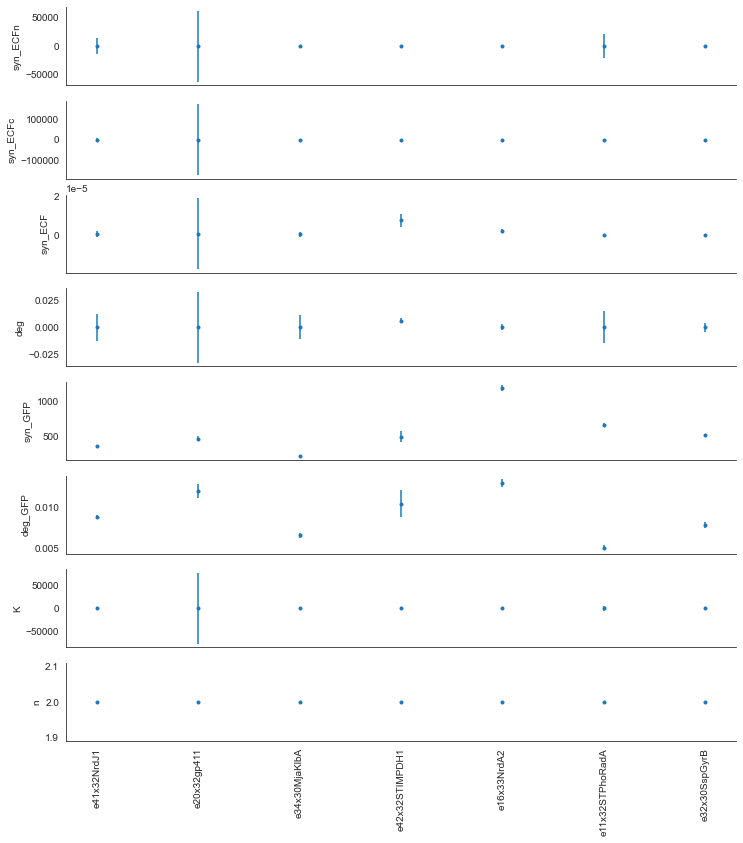

In [124]:
init_guess = [1e-6, 1e-3, 1e2, 1e-2, 2]
gate_bounds = [np.array(init_guess)*0, np.array(init_guess)*100]
plot_parameters(f_df_deg, gate_bounds)

### Simpler Model

In [23]:
#model
def hill_equation(x, n):
    return x**n / (1 + x**n)

def gate_wrapper_simple(t, syn_GFP, t_lag, y0):
    
    def gate_model(y, t):
    
        #dependent variables
        #ECFn, ECFc, ECF, GFP, OD = y
        
        #gamma = growth_rate(t, OD, alpha, beta)
        #dOD = gamma * OD
        
        #dECFn = syn_ECFn - (deg + gamma) * ECFn
        #dECFc = syn_ECFc - (deg + gamma) * ECFc
        #dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        if t > t_lag:
            dGFP = syn_GFP * (30000 - y)
        else:
            dGFP = 0.0

        return dGFP
    
    solution = odeint(gate_model, y0, t)
    return solution.transpose()

[1.36457993e-02 2.55466077e+02]


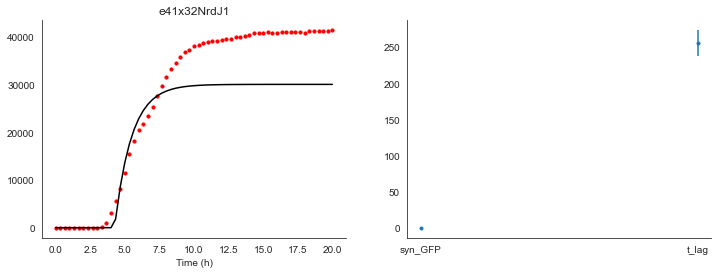

In [24]:
def fit_simple_gfp(idx):
    
    f_data = fluo_selected.iloc[:,idx]
    f_t = fluo_selected.index
    title = fluo_selected.columns[idx]
    #r, K, c0 = od_params[idx]
    y0 = 10
    #extra = (r, K)
    
    parameters = ['syn_GFP', 't_lag']
    init_guess = [1e-2, 180]
    gate_bounds_together = [[0, 0], [1e2, 300]]
    
    def model_fit(t, a, b):
        fit = gate_wrapper_simple(t, a, b, y0)
        return fit[0]
    
    f_params, f_cov = curve_fit(model_fit, f_t, f_data, p0=init_guess, bounds=gate_bounds_together)#, method='dogbox')
    print(f_params)
    f_sim = model_fit(f_t, *f_params)
    f_df = pd.DataFrame({'Parameters': parameters, 'Value': f_params, 'Err': np.sqrt(np.diag(f_cov))})
    return f_df, f_sim, f_data 

idx = 0
f_df, f_sim, f_data = fit_simple_gfp(idx)
f_t = f_data.index
f, axs = plt.subplots(1, 2, figsize=(12, 4))
compare_model_data(f_t, f_data, f_sim, axs[0])
axs[0].set_title(fluo_selected.columns[idx])
axs[1].errorbar(f_df['Parameters'], f_df['Value'], f_df['Err'], fmt='.')

sns.despine()

### Layering the Models

In [125]:
class Gate:
    def __init__(self, name, gate_params, od_params, fluo_data, od_data):
        
        #metadata
        self.name = name
        
        #parameters
        self.syn_ECFn = gate_params[0]
        self.syn_ECFc = gate_params[1]
        self.syn_ECF = gate_params[2]
        self.deg = gate_params[3]
        self.syn_GFP = gate_params[4]
        self.deg_GFP = gate_params[5]
        self.K = gate_params[6]
        self.n = gate_params[7]
        self.alpha = od_params[0]
        self.beta = od_params[1]
        self.gamma = 0
        
        #initial states
        self.ECFn = 0
        self.ECFc = 0
        self.ECF = 0
        self.GFP = 0
        self.OD = od_params[2]
        
        #derivative states
        self.dECFn = 0
        self.dECFc = 0
        self.dECF = 0
        self.dGFP = 0
        self.dOD = 0
        
        #connection
        self.connection = None
        
        #data
        self.fluo_data = fluo_data
        self.od_data = od_data
        
    def get_params(self):
        return [self.syn_ECFn, self.syn_ECFc, self.syn_ECF, self.deg, self.syn_GFP, self.deg_GFP, self.K, self.n, self.alpha, self.beta]
    
    def get_init_states(self):
        return [self.ECFn, self.ECFc, self.ECF, self.GFP, self.OD]
    
class Connection:
    def __init__(self, name, input1, input2, output, level, index, input1_idx, input2_idx, output_idx):
        self.name = name
        self.input1 = input1
        self.input2 = input2
        self.output = output
        self.level = level #0: input, 1: intermediate, 2:output
        self.index = index
        self.input1_idx = input1_idx
        self.input2_idx = input2_idx
        self.output_idx = output_idx
         
class Circuit:
    def __init__(self, fluo, od, gate_params, od_params, schema):
        
        #inducers
        self.inducers = [1] * 8
        
        #gate
        self.gates = [
            Gate('g00', gate_params[0], od_params[0], fluo.iloc[:,0], od.iloc[:,0])#,
            #Gate('g01', gate_params[1], od_params[1], fluo.iloc[:,1], od.iloc[:,1]),
            #Gate('g02', gate_params[2], od_params[2], fluo.iloc[:,2], od.iloc[:,2]),
            #Gate('g03', gate_params[3], od_params[3], fluo.iloc[:,3], od.iloc[:,3]),
            #Gate('g14', gate_params[4], od_params[4], fluo.iloc[:,4], od.iloc[:,4]),
            #Gate('g15', gate_params[5], od_params[5], fluo.iloc[:,5], od.iloc[:,5]),
            #Gate('g26', gate_params[6], od_params[6], fluo.iloc[:,6], od.iloc[:,6])
        ]
        self.connections = [
            Connection('c1', self.inducers[0], self.inducers[1], None, 0, 0, 0, 1, 4)
            #Connection('c1', self.inducers[0], self.inducers[1], self.gates[4], 0, 0, 0, 1, 4),
            #Connection('c2', self.inducers[2], self.inducers[3], self.gates[4], 0, 1, 2, 3, 4),
            #Connection('c3', self.inducers[4], self.inducers[5], self.gates[5], 0, 2, 4, 5, 5),
            #Connection('c4', self.inducers[6], self.inducers[7], self.gates[5], 0, 3, 6, 7, 5),
            #Connection('c5', self.gates[0], self.gates[1], self.gates[6], 1, 4, 0, 1, 6),
            #Connection('c6', self.gates[2], self.gates[3], self.gates[6], 1, 5, 2, 3, 6),
            #Connection('c7', self.gates[4], self.gates[5], self.gates[6], 2, 6, 4, 5, 6)
        ]
        
        for i, g in enumerate(self.gates):
            g.connection = self.connections[i]

    def get_all_params(self):
        params = []
        for g in self.gates:
            params.append(g.get_params())
        return np.array(params)
    
    def get_all_init_states(self):
        init_states = []
        for g in self.gates:
            init_states.append(g.get_init_states())
        return np.array(init_states)
    '''
    def gate_wrapper(t, syn_ECF, deg, syn_GFP, deg_GFP, n, alpha, beta, y0):
        
        def gate_model(y, t):

            #dependent variables
            ECFn, ECFc, ECF, GFP, OD = y

            gamma = growth_rate(t, OD, alpha, beta)
            #differential equations
            dOD = gamma * OD
            dECFn = 1 - (deg + gamma) * ECFn
            dECFc = 1 - (deg + gamma) * ECFc
            dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF

            dGFP = syn_GFP * hill_equation(ECF, n) - (deg_GFP + gamma) * GFP

            return [dECFn, dECFc, dECF, dGFP, dOD]

        solution = odeint(gate_model, y0, t)
        return solution.transpose()
    '''

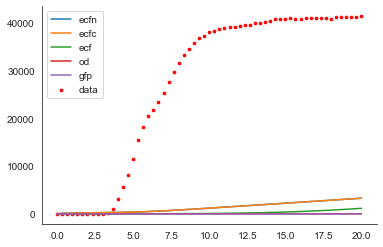

In [127]:
def hill_equation2(x, K, n):
    return x**n / (K**n + x**n)

def gate_wrapper2(t, circuit):
    
    y0_ = []
    
    for g in circuit.gates:
        y0_.append(g.get_init_states())
    y0 = np.array(y0_).ravel()
    
    def gate_model2(y, t):
        
        yi = np.reshape(y, (-1, 5))
        yn = []
        for i, g in enumerate(circuit.gates):
            
            g.ECFn, g.ECFc, g.ECF, g.GFP, g.OD = yi[i]
        
            #growth
            g.gamma = growth_rate(t, g.OD, g.alpha, g.beta)
            g.dOD = g.gamma * g.OD
            
            #level 0 (input)
            if g.connection.level==0:
                g.dECFn = g.syn_ECFn - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                g.GFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
                
            #level 1 (middle)
            elif g.connection.level==1:
                
                input1 = g.connection.input1
                input2 = g.connection.input2
                
                g.dECFn = g.syn_ECFn * hill_equation(input1.ECF, input1.K, input1.n) - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * hill_equation(input2.ECF, input2.K, input2.n) - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
               
            #level 2 (output)
            elif g.connection.level==2:
                
                input1 = g.connection.input1
                input2 = g.connection.input2
                
                g.dECFn = g.syn_ECFn * hill_equation(input1.ECF, input1.K, input1.n) - (g.deg + g.gamma) * g.ECFn
                g.dECFc = g.syn_ECFc * hill_equation(input2.ECF, input2.K, input2.n) - (g.deg + g.gamma) * g.ECFc
                g.dECF = g.syn_ECF * g.ECFn * g.ECFc - (g.deg + g.gamma) * g.ECF
                g.GFP = g.syn_GFP * hill_equation(g.ECF, g.K, g.n) - (g.deg + g.gamma) * g.GFP
                
                yn.append([g.dECFn, g.dECFc, g.dECF, g.dGFP, g.dOD])
        
        return np.array(yn).ravel()
    
    solution = odeint(gate_model2, y0, t)
    return solution.transpose()


#sel = 7
#fluo_selected = fluo.iloc[:,:sel]
#od_selected = od.iloc[:,:sel]
gate_params = [par['Value'] for par in f_df_deg]
#print(gate_params)


#od_params_selected = od_params[:sel]
circuit = Circuit(fluo_selected, od_selected, gate_params, od_params, None)
#circuit.get_all_params(), circuit.get_all_init_states()


f_t = fluo.index
#f_data = fluo.iloc[:,0]
#alpha, beta, c0 = od_params[0]

#params = [3.49222058e+00, 3.71564938e+00, 3.23826764e-07, 1.02465159e-05,
#              3.65145688e+02, 8.88510834e-03, 1.62878098e+00, 2.00000000e+00, alpha, beta]
#params = circuit.get_all_params()
#y0 = [0, 0, 0, 0, c0]
#y0 = circuit.get_all_init_states()

#def model_fit(t, params):
#    fit = gate_wrapper(t, gates)
#    return fit

model = gate_wrapper2(f_t, circuit)
ecfn = pd.Series(model[0], index=f_t/60)
ecfc = pd.Series(model[1], index=f_t/60)
ecf = pd.Series(model[2], index=f_t/60)
gfp = pd.Series(model[3], index=f_t/60)
od = pd.Series(model[4], index=f_t/60)

plt.scatter(f_t/60, f_data, s=7, c='r', label='data')
plt.plot(ecfn, label='ecfn')
plt.plot(ecfn, label='ecfc')
plt.plot(ecf, label='ecf')
plt.plot(od, label='od')
plt.plot(gfp, label='gfp')
plt.legend()

#plt.scatter(f_t/60, f_data, s=7, c='r', label='data')
#for m in model[:8]:
#    plt.plot(pd.Series(m, index=f_t/60))
sns.despine()
plt.show()

In [130]:
def gate_wrapper3(t, params, extra, y0):
    
    #fixed parameters
    syn_ECF, deg, syn_GFP, deg_GFP, n = params
    alpha, beta = extra

    def gate_model3(y, t):
    
        #dependent variables
        ECFn, ECFc, ECF, GFP, OD = y
        
        gamma = growth_rate(t, OD, alpha, beta)
        #differential equations
        dOD = gamma * OD
        dECFn = 1 - (deg + gamma) * ECFn
        dECFc = 1 - (deg + gamma) * ECFc
        dECF = syn_ECF * ECFn * ECFc - (deg + gamma) * ECF
        
        dGFP = syn_GFP * hill_equation(ECF, n) - (deg_GFP + gamma) * GFP

        return [dECFn, dECFc, dECF, dGFP, dOD]
    
    solution = odeint(gate_model3, y0, t)
    return solution.transpose()

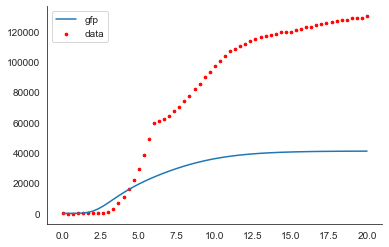

In [140]:
def plot_model3(idx, fluo=fluo_selected, od_params=od_params, show_data=True, show_all=False):

    f_data = fluo.iloc[:,idx]
    f_t = fluo.index
    alpha, beta, c0 = od_params[idx]
    y0 = [0, 0, 0, 0, c0]
    extra = (alpha, beta)
    params = [3.49222058e+00, 3.71564938e+00, 3.23826764e-07, 1.02465159e-05,
              3.65145688e+02, 8.88510834e-03, 1.62878098e+00, 2.00000000e+00]
    
    def model_fit3(t, a, b, c, d, e, f, g, h):
        fit = gate_wrapper(t, a, b, c, d, e, f, g, h, extra, y0)
        return fit
    
    model = model_fit3(f_t, *params)
    ecfn = pd.Series(model[0], index=f_t/60)
    ecfc = pd.Series(model[1], index=f_t/60)
    ecf = pd.Series(model[2], index=f_t/60)
    gfp = pd.Series(model[3], index=f_t/60)
    od = pd.Series(model[4], index=f_t/60)

    if show_data:
        plt.scatter(f_t/60, f_data, s=7, c='r', label='data')
    if show_all:
        plt.plot(ecfn, label='ecfn')
        plt.plot(ecfn, label='ecfc')
        plt.plot(ecf, label='ecf')
        plt.plot(od, label='od')
    plt.plot(gfp, label='gfp')
    plt.legend()
    sns.despine()
    plt.show()
    
plot_model3(5)